**1. IMPORT PACKAGE**

In [1]:
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
init_notebook_mode(connected=True)

# Machine Learning imports
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import string
import re
from string import punctuation
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. IMPORT DATA**

In [5]:
df= pd.read_excel('/content/drive/My Drive/Data Latih BDC (1).xlsx')
df

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg
...,...,...,...,...,...,...
4226,999287,1,2016-01-17 00:00:00,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg
4227,999472,1,2020-08-20 00:00:00,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,999472.png
4228,999501,1,2020-08-17 00:00:00,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,999501.jpg
4229,999848,1,2020-07-21 00:00:00,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,999848.jpg


**3. Preprocessing Data**

In [6]:
columns = ['tanggal' ,'nama file gambar']
df.drop(columns, inplace=True, axis=1)

In [7]:
df

,ID,label,judul,narasi
0,71,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...
1,461,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...
2,495,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...
3,550,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k..."
4,681,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .
...,...,...,...,...
4226,999287,1,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...
4227,999472,1,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...
4228,999501,1,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny
4229,999848,1,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...


In [8]:
df['teks']=df['judul'].astype(str)+' '+df['narasi'].astype(str)
col=['judul', 'narasi']
df.drop(col, inplace=True, axis=1)

In [9]:
df

,ID,label,teks
0,71,1,Pemakaian Masker Menyebabkan Penyakit Legionna...
1,461,1,Instruksi Gubernur Jateng tentang penilangan ...
2,495,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...
3,550,1,"ini bukan politik, tapi kenyataan Pak Jokowi b..."
4,681,1,Foto Kadrun kalo lihat foto ini panas dingin K...
...,...,...,...
4226,999287,1,: KPK Dilarang Membawa Brimob Bersenjata Masuk...
4227,999472,1,Foto pejabat keuangan dibawah palu arit Jangan...
4228,999501,1,Gambar Denny Siregar Musuh Warga Tasikmalaya d...
4229,999848,1,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...


In [10]:
# helper function to clean text
def processTeks(teks):
    # Remove HTML special entities (e.g. &amp;)
    teks = re.sub(r'\&\w*;', '', teks)
    #Convert @username to AT_USER
    teks = re.sub('@[^\s]+','',teks)
    # Remove tickers
    teks = re.sub(r'\$\w*', '', teks)
    # To lowercase
    teks = teks.lower()
    # Remove hyperlinks
    teks = re.sub(r'https?:\/\/.*\/\w*', '', teks)
    # Remove hashtags
    teks = re.sub(r'#\w*', '', teks)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    teks = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', teks)
    # Remove words with 2 or fewer letters
    teks = re.sub(r'\b\w{1,2}\b', '', teks)
    # Remove whitespace (including new line characters)
    teks = re.sub(r'\s\s+', ' ', teks)
    # Remove single space remaining at the front of the tweet.
    teks = teks.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    teks = ''.join(c for c in teks if c <= '\uFFFF') 
    return teks

In [11]:
# clean dataframe's text column
df['teks'] = df['teks'].apply(processTeks)
# preview some cleaned tweets
df['teks'].head()

0    pemakaian masker menyebabkan penyakit legionna...
1    instruksi gubernur jateng tentang penilangan b...
2    foto jim rohn jokowi adalah presiden terbaik d...
3    ini bukan politik tapi kenyataan pak jokowi be...
4    foto kadrun kalo lihat foto ini panas dingin k...
Name: teks, dtype: object

In [12]:
# drop duplicates
df = df.drop_duplicates('teks')
df.shape

(4226, 3)

In [13]:
#stopwords
lstfile = open('/content/drive/My Drive/stopword id en.txt','r')
lst = lstfile.readlines()
lst = [x.strip() for x in lst] 
# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in lst]

# -------------------------------------------

# tokenize message column and create a column for tokens
df = df.copy()
df['tokens'] = df['teks'].apply(text_process) # tokenize style 1
df[['teks','tokens']].head(20)

,teks,tokens
0,pemakaian masker menyebabkan penyakit legionna...,"[pemakaian, masker, menyebabkan, penyakit, leg..."
1,instruksi gubernur jateng tentang penilangan b...,"[instruksi, gubernur, jateng, penilangan, berm..."
2,foto jim rohn jokowi adalah presiden terbaik d...,"[foto, jim, rohn, jokowi, presiden, terbaik, d..."
3,ini bukan politik tapi kenyataan pak jokowi be...,"[politik, kenyataan, jokowi, berhasil, memulan..."
4,foto kadrun kalo lihat foto ini panas dingin k...,"[foto, kadrun, kalo, lihat, foto, panas, dingi..."
5,event promo smartphone jne 2020 spesial bulan ...,"[event, promo, smartphone, jne, 2020, spesial,..."
6,mereka sudah mempersiapkan diri dengan baik un...,"[menguasai, negri, lihatlah, menguasai, negri]"
7,foto presiden italia menangis karena tak cukup...,"[foto, presiden, italia, menangis, lahan, meng..."
8,kapolres timor tengah utara nusa tenggara timu...,"[kapolres, timor, utara, nusa, tenggara, timur..."
9,video polisi china telah menganiaya wanita uig...,"[video, polisi, china, menganiaya, wanita, uig..."


In [14]:
#word cload
all_words = []
for line in df['tokens']: 
    all_words.extend(line)  
# create a word frequency dictionary
wordfreq = Counter(all_words)
wordfreq.most_common(10)

[('indonesia', 748),
 ('jokowi', 578),
 ('foto', 524),
 ('orang', 499),
 ('video', 433),
 ('corona', 398),
 ('virus', 385),
 ('anak', 368),
 ('china', 347),
 ('covid', 343)]

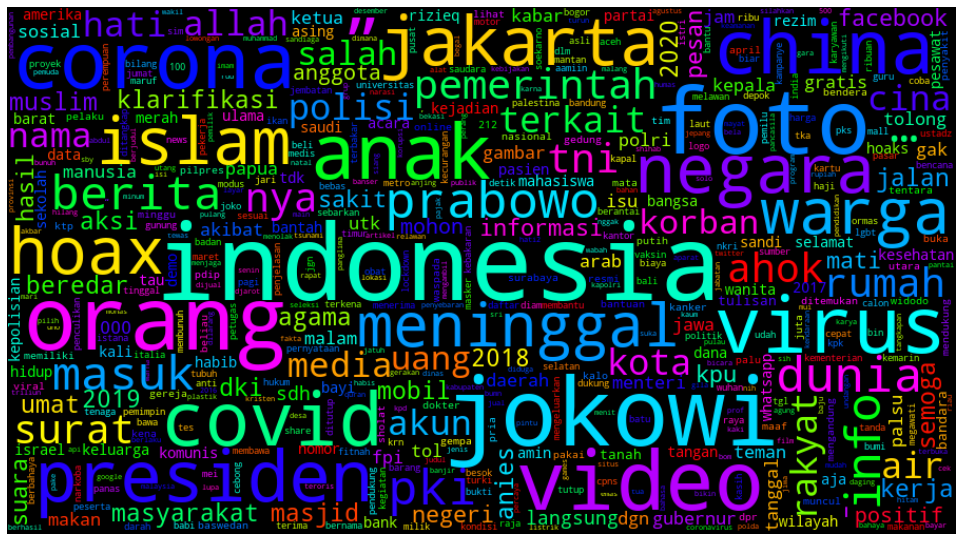

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='gist_rainbow',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['teks'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))
# example of vectorized text
sample_teks = df['teks'][0]
print(sample_teks)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_teks])
print(bow_sample)
print('\n')

19699
pemakaian masker menyebabkan penyakit legionnaires caller radio talk show recently shared that his wife was hospitalized told she had covid only couple days left live doctor friend suggested she tested for legionnaires disease because she wore the same mask every day all day long turns out was legionnaires disease from the moisture bacteria her mask she was given antibiotics within two days was better what these ‘spikes’ covid are really something else due ‘mask induced infections’ 


  (0, 967)	1
  (0, 1368)	1
  (0, 3007)	1
  (0, 3477)	1
  (0, 3484)	2
  (0, 3688)	2
  (0, 3693)	2
  (0, 4652)	2
  (0, 4950)	1
  (0, 5642)	1
  (0, 6573)	1
  (0, 6884)	1
  (0, 6899)	1
  (0, 9429)	1
  (0, 9438)	3
  (0, 9629)	1
  (0, 10095)	2
  (0, 10097)	1
  (0, 11257)	1
  (0, 11689)	1
  (0, 13115)	1
  (0, 13631)	1
  (0, 14686)	1
  (0, 16157)	1
  (0, 16808)	1
  (0, 17126)	1
  (0, 17751)	1
  (0, 17962)	1
  (0, 18769)	1
  (0, 18834)	1
  (0, 19159)	1
  (0, 19183)	1




In [17]:
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df['teks'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (4226, 19699)
Amount of Non-Zero occurences:  72090


In [18]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 19183)	0.1522437236148884
  (0, 19159)	0.1522437236148884
  (0, 18834)	0.1522437236148884
  (0, 18769)	0.1329213020097921
  (0, 17962)	0.14511239271149928
  (0, 17751)	0.14005263291318118
  (0, 17126)	0.14511239271149928
  (0, 16808)	0.1522437236148884
  (0, 16157)	0.14511239271149928
  (0, 14686)	0.14005263291318118
  (0, 13631)	0.09787838827402011
  (0, 13115)	0.13021009582990717
  (0, 11689)	0.1522437236148884
  (0, 11257)	0.1135988804046958
  (0, 10097)	0.10293814807233824
  (0, 10095)	0.25572308442294794
  (0, 9629)	0.13021009582990717
  (0, 9438)	0.43533717813449785
  (0, 9429)	0.13021009582990717
  (0, 6899)	0.1522437236148884
  (0, 6884)	0.1522437236148884
  (0, 6573)	0.1522437236148884
  (0, 5642)	0.1522437236148884
  (0, 4950)	0.13612797830898155
  (0, 4652)	0.2658426040195842
  (0, 3693)	0.26042019165981434
  (0, 3688)	0.2658426040195842
  (0, 3484)	0.1409474001335324
  (0, 3477)	0.14511239271149928
  (0, 3007)	0.1522437236148884
  (0, 1368)	0.14005263291318118
  (0, 9

In [19]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['corona']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['2020']])

3.9331473983623697
4.83838829404994


In [20]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4226, 19699)


Training

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['teks'], df['label'], test_size=0.2, random_state=123)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2), (1,3)],
               'bow__min_df':(2,3,4,5,6,7,8,9,10),
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-1, 1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 14.0min finished



Best Model: 0.835207 using {'bow__min_df': 7, 'bow__ngram_range': (1, 3), 'classifier__alpha': 0.1, 'tfidf__use_idf': False}


Mean: 0.827515 Stdev:(0.008681) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': True}
Mean: 0.829586 Stdev:(0.009281) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': False}
Mean: 0.822189 Stdev:(0.005030) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.827219 Stdev:(0.007026) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.820414 Stdev:(0.008477) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.823669 Stdev:(0.008284) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.828402 Stdev:(0.013297) with: {'bow__min_df':

In [22]:
# save best model to current working directory
joblib.dump(grid, "model_NB.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("model_NB.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.8522458628841607


confusion matrix: 
 [[ 33 114]
 [ 11 688]]


              precision    recall  f1-score   support

           0       0.75      0.22      0.35       147
           1       0.86      0.98      0.92       699

    accuracy                           0.85       846
   macro avg       0.80      0.60      0.63       846
weighted avg       0.84      0.85      0.82       846



In [ ]:
print(y_train)
print(X_train)

1057    0
2927    1
569     1
2121    1
2667    0
       ..
4114    0
3999    1
2607    1
2373    1
1499    1
Name: label, Length: 3380, dtype: int64
1057    mudah mudahan masih banyak rakyat lugu yang ma...
2927    orang ini telah meludahi quran dan mengencingi...
569     surat pemberitahuan pengangkatan pns tanpa tes...
2121    kejadian tadi siang jam embong malang sby keja...
2667    aji pontianak gelar pelatihan anti hoaks rri a...
                              ...                        
4114    santunan duta besar china kepada pbnu dubes ch...
3999    berita mengerikan akhirnya dibuka untuk publik...
2607    bunga mahameru arya yang mekar 400 tahun sekal...
2373    mobil pemuda yang berkelahi dengan lettu tni t...
1499    suntik sebabkan kista ovarium hanya sekedar me...
Name: teks, Length: 3380, dtype: object


Predict

In [ ]:
# run predictions on twitter data
teks_preds = model_NB.predict(df['teks'])

# append predictions to dataframe
df_teks_preds = df.copy()
df_teks_preds['predictions'] = teks_preds
df_teks_preds.shape

(4226, 5)

In [ ]:
df_teks_preds

,ID,label,teks,tokens,predictions
0,71,1,pemakaian masker menyebabkan penyakit legionna...,"[pemakaian, masker, menyebabkan, penyakit, leg...",1
1,461,1,instruksi gubernur jateng tentang penilangan b...,"[instruksi, gubernur, jateng, penilangan, berm...",1
2,495,1,foto jim rohn jokowi adalah presiden terbaik d...,"[foto, jim, rohn, jokowi, presiden, terbaik, d...",1
3,550,1,ini bukan politik tapi kenyataan pak jokowi be...,"[politik, kenyataan, jokowi, berhasil, memulan...",1
4,681,1,foto kadrun kalo lihat foto ini panas dingin k...,"[foto, kadrun, kalo, lihat, foto, panas, dingi...",1
...,...,...,...,...,...
4226,999287,1,kpk dilarang membawa brimob bersenjata masuk g...,"[kpk, dilarang, membawa, brimob, bersenjata, m...",1
4227,999472,1,foto pejabat keuangan dibawah palu arit jangan...,"[foto, pejabat, keuangan, dibawah, palu, arit,...",1
4228,999501,1,gambar denny siregar musuh warga tasikmalaya b...,"[gambar, denny, siregar, musuh, warga, tasikma...",1
4229,999848,1,kaesang bapak saya dengan kesederhaan bisa nip...,"[kaesang, kesederhaan, nipu, rakyat, indonesia...",1


In [ ]:
df_teks_preds.to_excel('/content/drive/My Drive/predict data latih.xlsx', index=False)

In [ ]:
pos = df_teks_preds.predictions.value_counts()[0]
neg = df_teks_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 3558, Negatives - 668


In [ ]:
import plotly.graph_objs as go

labels = ['Positif','Negatif']
values = [int(pos),int(neg)]

trace = go.Pie(labels=labels, values=values)
iplot([trace], filename='basic_pie_chart')

Predict Data Uji

In [ ]:
dfp= pd.read_excel('/content/drive/My Drive/Data Uji BDC (1).xlsx')
dfp

,ID,tanggal,judul,narasi,nama file gambar
0,238057,2020-07-13 00:00:00,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,238057.jpg
1,238158,2020-07-06 00:00:00,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...,238158.jpg
2,238865,2020-04-22 00:00:00,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...,238865.jpg
3,248298,2019-10-22 00:00:00,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,248298.jpg
4,255176,2020-05-01 00:00:00,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran...",255176.jpg
...,...,...,...,...,...
465,206021,2020-05-01 00:00:00,"Dijemput oleh Tim Medis, Kakak Beradik Usia 8 ...","DiTangerang, dua bersaudara kakak beradik usia...",206021.jpg
466,219874,2017-10-02 00:00:00,": Pertanda Alam, Kera Putih Mulai Turun Dari G...","Pertanda Alam, Kera Putih Mulai Turun Dari Gun...",219874.jpg
467,222802,2020-03-22 00:00:00,Pasar Wameo dan Karya Nugraha di Tutup selama ...,Assalamu Alaikum …\n \n Info dari pedagang pa...,222802.jpg
468,226020,2018-09-25 00:00:00,Klarifikasi KPK Terkait Foto Setya Novanto Tan...,Secara tidak sengaja sekitar pukul 06.00 WIB d...,226020.jpg


In [ ]:
columns = [ 'tanggal' ,'nama file gambar']
dfp.drop(columns, inplace=True, axis=1)

In [ ]:
dfp

,ID,judul,narasi
0,238057,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...
1,238158,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...
2,238865,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...
3,248298,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...
4,255176,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran..."
...,...,...,...
465,206021,"Dijemput oleh Tim Medis, Kakak Beradik Usia 8 ...","DiTangerang, dua bersaudara kakak beradik usia..."
466,219874,": Pertanda Alam, Kera Putih Mulai Turun Dari G...","Pertanda Alam, Kera Putih Mulai Turun Dari Gun..."
467,222802,Pasar Wameo dan Karya Nugraha di Tutup selama ...,Assalamu Alaikum …\n \n Info dari pedagang pa...
468,226020,Klarifikasi KPK Terkait Foto Setya Novanto Tan...,Secara tidak sengaja sekitar pukul 06.00 WIB d...


In [ ]:
dfp['teks']=dfp['judul'].astype(str)+' '+dfp['narasi'].astype(str)
col=['judul', 'narasi']
dfp.drop(col, inplace=True, axis=1)

In [ ]:
# run predictions on twitter data
teksp_preds = model_NB.predict(dfp['teks'])

# append predictions to dataframe
dfp_teksp_preds = dfp.copy()
dfp_teksp_preds['prediksi'] = teksp_preds
dfp_teksp_preds.shape

(470, 3)

In [ ]:
dfp2_teksp_preds = dfp_teksp_preds
col=['teks']
dfp2_teksp_preds.drop(col, inplace=True, axis=1)

In [ ]:
dfp2_teksp_preds.to_csv('/content/drive/My Drive/predict data uji.csv', index=False)

In [ ]:
posp = dfp_teksp_preds.predictions.value_counts()[0]
negp = dfp_teksp_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(posp,negp))

Model predictions: Positives - 29, Negatives - 441


In [ ]:
import plotly.graph_objs as go

labels = ['Positif','Negatif']
values = [int(posp),int(negp)]

trace = go.Pie(labels=labels, values=values)
iplot([trace], filename='basic_pie_chart')